100%|██████████| 30000/30000 [00:40<00:00, 732.46it/s]


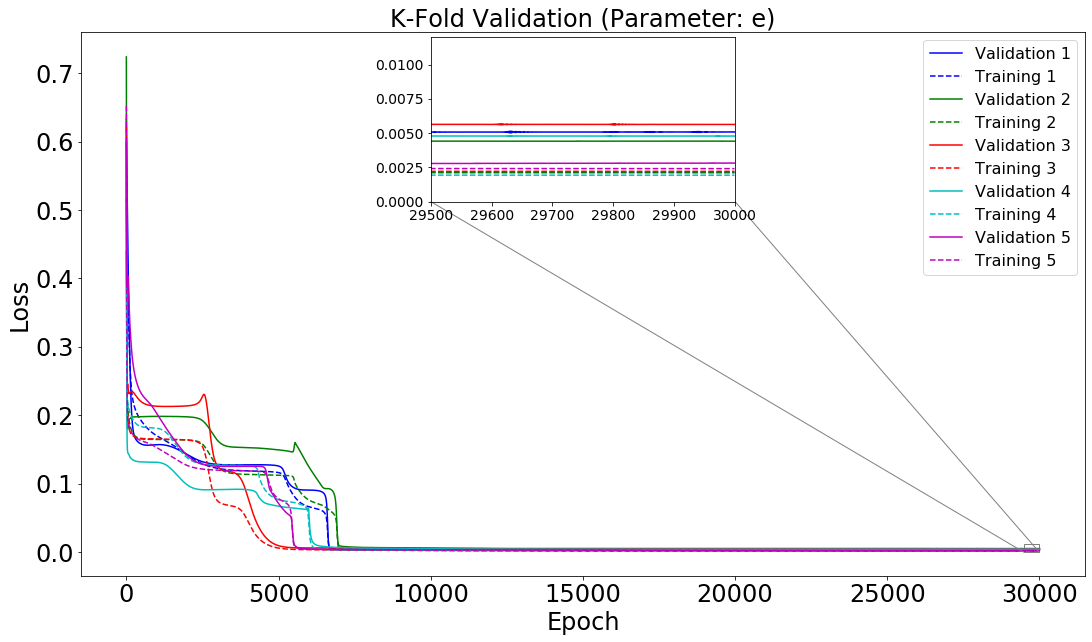

In [5]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import numpy as np
import pandas as pd
import functions as f
import torch
from torch import autograd, nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from tqdm import tqdm
import sys

# ALL DATASET
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")

par = "e"

dataset = np.stack((data["x"].values, data["y"].values, data[par]), axis=1)
dataset = torch.from_numpy(dataset).float()

X = dataset[:,:2]
y = dataset[:,2]

# Parametri che servono per la normalizzazione
data_max = data[par].max()
data_min = data[par].min()


# ## PARAMETRI
# Definisco ora tutti i parametri in modo che siano facilmente modificabili

# In[2]:


input_size = 2
hidden_size = 7
activation_fun = nn.Tanh()
epochs = 30000
loss_fun = nn.MSELoss()

# In[4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = activation_fun
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, input):
        hidden = self.hidden(input)
        activated = self.activation(hidden)
        output = self.output(activated)       
        return self.activation(output)

net = Net()
opt = optim.Adam(net.parameters(), lr=0.001)


# Funzione per inizializzare i pesi della rete
# In[5]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0.0)



fig, ax = plt.subplots(figsize=(18,10))
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.title(f'K-Fold Validation (Parameter: {par})', fontsize=24)

axins = zoomed_inset_axes(ax, zoom=20, loc=9)

# ## Testo la rete utilizzando KFold
# In[7]:

kf = KFold(n_splits=5)    
i = 0

# carico il dataset e lo mescolo
dataset = np.stack((data["x"].values, data["y"].values, data[par]), axis=1)
np.random.shuffle(dataset)
shuffled = torch.from_numpy(dataset).float()

net.train()
colors = ['b', 'g', 'r', 'c', 'm']

X = shuffled[:,:2]
y = shuffled[:,2]

for train_index, val_index in kf.split(shuffled):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    y_train = f.normalization2(y_train, data_max, data_min)
    y_val = f.normalization2(y_val, data_max, data_min)

    net.apply(init_weights)
    training_loss = []
    validation_loss = []

    for epoch in tqdm(range(epochs)):
        opt.zero_grad()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = loss_fun(y_train, y_pred)
        training_loss.append(train_loss)

        with torch.no_grad():
            y_test = net(X_val)
            y_test = torch.squeeze(y_test)
            val_loss = loss_fun(y_val, y_test)
            assert val_loss.requires_grad == False
            validation_loss.append(val_loss)

        train_loss.backward()
        opt.step()

    ax.plot(validation_loss, label=f'Validation {i+1}', ls='-', color=colors[i])
    ax.plot(training_loss, label=f'Training {i+1}', ls='dashed', color=colors[i])
    axins.plot(validation_loss, ls='-', color=colors[i])
    axins.plot(training_loss, ls='dashed', color=colors[i])
    
    i += 1
    

x1, x2, y1, y2 = 29500, 30000, 0, 0.012
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
ax.tick_params(axis='both', labelsize=24)
axins.tick_params(axis='both', labelsize=14)
ax.legend(loc='upper right', fontsize=16)
plt.savefig(f"./Plots/Test_1L_Tanh_{par}Zoom.pdf", dpi=400)
plt.show()

In [4]:
ax.set_xlabel('Epoch', fontsize=24)
ax.set_ylabel('Loss', fontsize=24)
ax.set_title(f'K-Fold Validation (Parameter: {par})', fontsize=24)
ax.tick_params(axis='both', labelsize=24)
ax.legend(loc='upper right', fontsize=16)

x1, x2, y1, y2 = 2000, 3000, 0.05, 0.19
axins = zoomed_inset_axes(ax, zoom=2, loc=1)
axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

#plt.savefig(f"./Plots/Test_1L_Sigmoid_{par}Zoom.png", dpi=400)
plt.show()